In [2]:
import cv2
from evaluation_utils import *
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
from random import shuffle

In [3]:
test_files = read_text_lines( "%s/%s" % ('filenames','eigen_test_files.txt') )
gt_files, gt_calib, im_sizes, im_files, cams = read_file_data(test_files, '/data/gengshay/KITTI/')

0 files missing


In [4]:
pred_disp_path = '/scratch/gengshay/tmp/supl2+sm_1l_upsamp_8b/disparities.npy'
min_depth = 1e-3
max_depth = 80

In [5]:
len(im_files)

697

In [6]:
num_samples = len(im_files)
pred_disparities = np.load(pred_disp_path)
gt_depths = []
pred_depths = []
for t_id in range(num_samples):
    camera_id = cams[t_id]  # 2 is left, 3 is right
    depth = generate_depth_map(gt_calib[t_id], gt_files[t_id], im_sizes[t_id], camera_id, False, True)
    gt_depths.append(depth.astype(np.float32))
    
    disp_pred = cv2.resize(pred_disparities[t_id], (im_sizes[t_id][1], im_sizes[t_id][0]), interpolation=cv2.INTER_LINEAR)
    disp_pred = disp_pred * 1000

    # need to convert from disparity to depth
    #focal_length, baseline = get_focal_length_baseline(gt_calib[t_id], camera_id)
    #depth_pred = (baseline * focal_length) / disp_pred
    depth_pred = disp_pred
    depth_pred[np.isinf(depth_pred)] = 0
    pred_depths.append(depth_pred)

In [7]:
rms     = np.zeros(num_samples, np.float32)
log_rms = np.zeros(num_samples, np.float32)
abs_rel = np.zeros(num_samples, np.float32)
sq_rel  = np.zeros(num_samples, np.float32)
d1_all  = np.zeros(num_samples, np.float32)
a1      = np.zeros(num_samples, np.float32)
a2      = np.zeros(num_samples, np.float32)
a3      = np.zeros(num_samples, np.float32)
abs_rel_a = []
sq_rel_a = []
a_a = []
abs_a = []
sq_a = []
log_sq_a = []

for i in range(num_samples):
    gt_depth = gt_depths[i]
    pred_depth = pred_depths[i]

    pred_depth[pred_depth < min_depth] = min_depth
    pred_depth[pred_depth > max_depth] = max_depth
    
    mask = np.logical_and(gt_depth > min_depth, gt_depth < max_depth)

    gt_height, gt_width = gt_depth.shape

    crop = np.array([0.40810811 * gt_height,  0.99189189 * gt_height,   
                     0.03594771 * gt_width,   0.96405229 * gt_width]).astype(np.int32)

    crop_mask = np.zeros(mask.shape)
    crop_mask[crop[0]:crop[1],crop[2]:crop[3]] = 1
    mask = np.logical_and(mask, crop_mask)
    abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = compute_errors(gt_depth[mask], pred_depth[mask])
    
    abs_rel_a.append( np.abs(gt_depth[mask] - pred_depth[mask])/ gt_depth[mask])
    abs_a.append( np.abs(gt_depth[mask] - pred_depth[mask]))
    sq_rel_a.append(np.square(gt_depth[mask] - pred_depth[mask])/ gt_depth[mask])
    sq_a.append(np.square(gt_depth[mask] - pred_depth[mask]))
    log_sq_a.append(np.square(np.log(gt_depth[mask]) - np.log(pred_depth[mask])))
    a_a.append(np.max([gt_depth[mask] / pred_depth[mask],pred_depth[mask] / gt_depth[mask]],0))

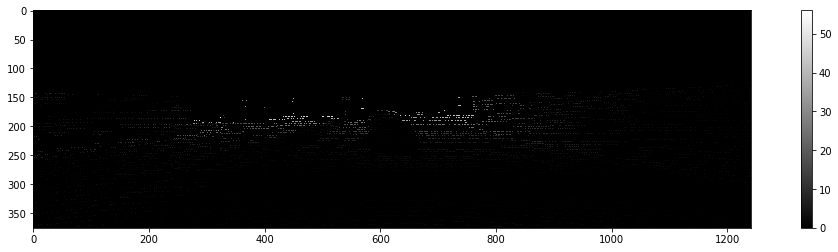

In [11]:
crop = np.array([0.40810811 * gt_height,  0.99189189 * gt_height,   
                     0.03594771 * gt_width,   0.96405229 * gt_width]).astype(np.int32)

crop_mask = np.zeros(mask.shape)
crop_mask[crop[0]:crop[1],crop[2]:crop[3]] = 1
im = pred_depths[-1]
im = abs(pred_depths[-1] - gt_depths[-1])
im[~crop_mask.astype(int)] = 0
im[gt_depths[-1]==0] = 0
plt.figure(figsize=(18,4))
plt.imshow(im,cmap='gray')
#plt.imshow(gt_depths[-1])
plt.colorbar()

In [9]:
print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'd1_all', 'a1', 'a2', 'a3'))
print("{:10.4f}, {:10.4f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), d1_all.mean(), a1.mean(), a2.mean(), a3.mean()))

   abs_rel,     sq_rel,        rms,    log_rms,     d1_all,         a1,         a2,         a3
    0.2368,     2.4944,      9.630,      0.390,      0.000,      0.569,      0.794,      0.895


In [28]:
def show_error(data,r,t):
    fig = plt.figure(figsize = (20,5))
    plt.hist(np.concatenate(data).ravel(),bins=1000,range=r);
    plt.axvline(x=np.mean(np.concatenate(data).ravel()), color='r');
    plt.title(t);

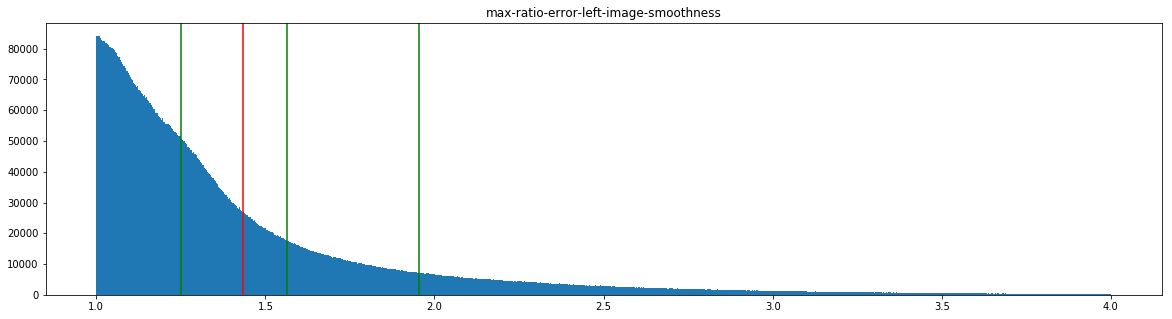

In [30]:
show_error(a_a,(1,4),'max-ratio-error-left-image-smoothness')
plt.axvline(x=1.25, color='g');plt.axvline(x=1.5625, color='g');plt.axvline(x=1.953125, color='g');

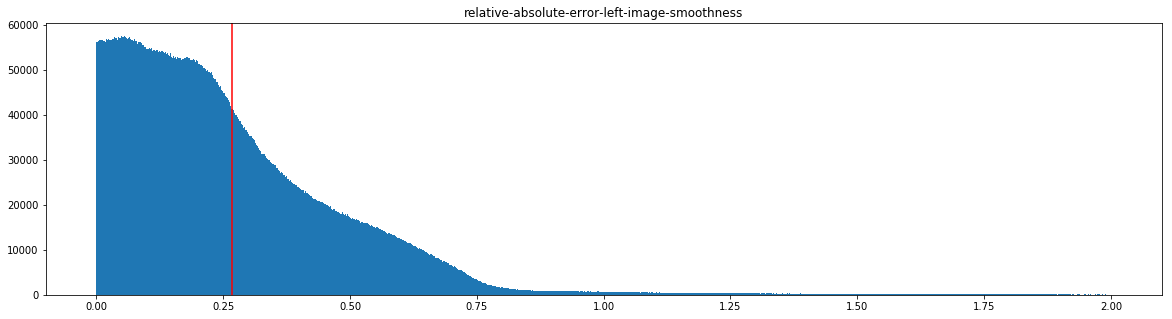

In [31]:
show_error(abs_rel_a,(0,2),'relative-absolute-error-left-image-smoothness')

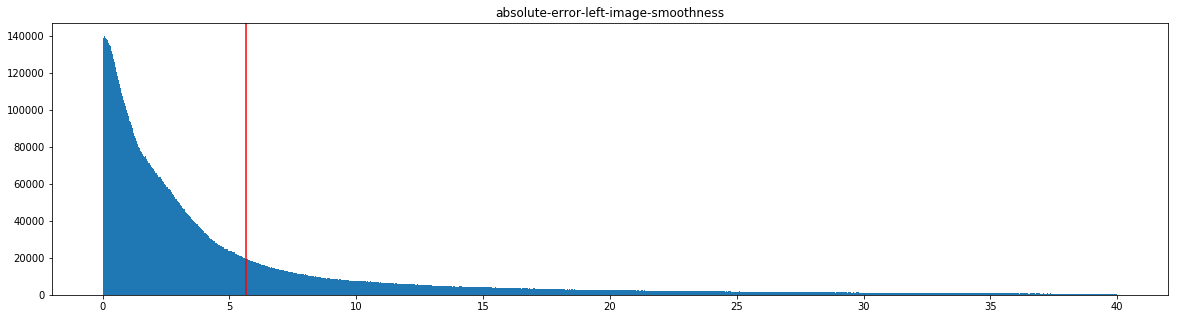

In [32]:
show_error(abs_a,(0,40),'absolute-error-left-image-smoothness')

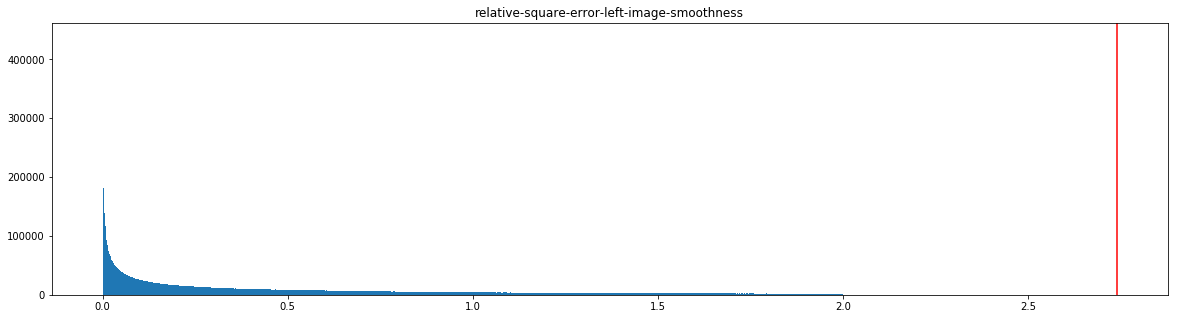

In [33]:
show_error(sq_rel_a,(0,2),'relative-square-error-left-image-smoothness')

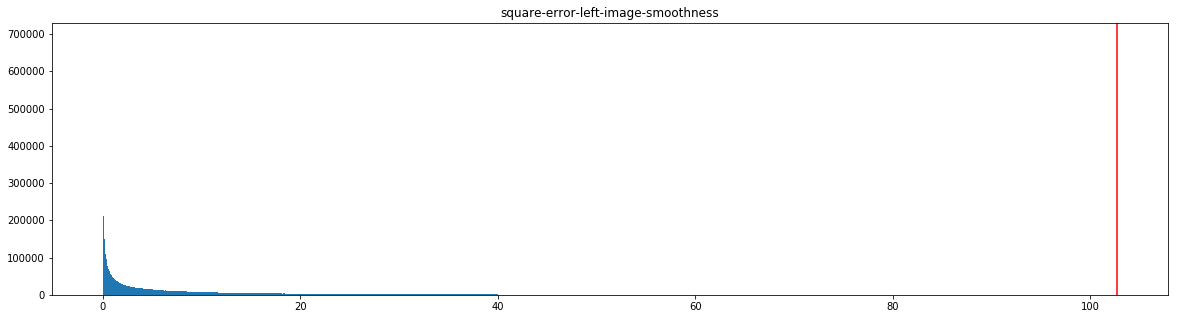

In [34]:
show_error(sq_a,(0,40),'square-error-left-image-smoothness')

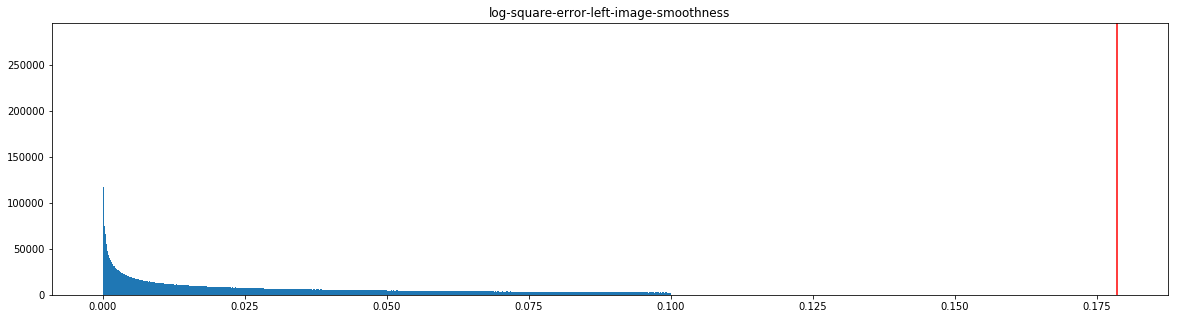

In [35]:
show_error(log_sq_a,(0,0.1),'log-square-error-left-image-smoothness')